In [5]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
from shapely import wkt

nyc_map_path = 'data/MODZCTA_20250409.geojson'
nyc_income_path = 'data/ACSST5Y2023.S1903_2025-04-09T104535/ACSST5Y2023.S1903-Data.csv'
nyc_demographics_path = 'data/ACSDP5Y2023.DP05_2025-04-09T124250/ACSDP5Y2023.DP05-Data.csv'
nyc_property_value_path = 'data/ACSDP5Y2023.DP04_2025-04-09T161430/ACSDP5Y2023.DP04-Data.csv'
nyc_education_path = 'data/ACSDP5Y2023.DP02_2025-04-09T124018/ACSDP5Y2023.DP02-Data.csv'

In [33]:
gdf = gpd.read_file(nyc_map_path)
income_data = pd.read_csv(nyc_income_path)
income_data = income_data[['NAME', 'S1903_C03_015E']]
income_data = income_data.rename(columns={
    'NAME': 'ZCTA', 
    'S1903_C03_015E': 'Median_Household_Income'
})
income_data = income_data.iloc[1:]
#print(income_data.head())

income_data['ZCTA'] = income_data['ZCTA'].str.extract(r'ZCTA5\s(\d+)')
income_data['Median_Household_Income'] = income_data['Median_Household_Income'].replace('250,000+', '250000')
income_data['Median_Household_Income'] = pd.to_numeric(income_data['Median_Household_Income'], errors='coerce')

#print(income_data.head())
gdf['ZCTA'] = gdf['modzcta'].astype(str)
# Merge geospatial data with income data
merged_gdf = gdf.merge(income_data, on='ZCTA', how='left')

In [39]:
education_data = pd.read_csv(nyc_education_path)
# Select relevant columns from social data
edu_data = education_data[['NAME', 'DP02_0068E']]
# Rename columns for better readability
edu_data = edu_data.rename(columns={
    'NAME': 'ZCTA',
    'DP02_0068E' : 'Bachelors_Degree_or_Higher',
})
edu_data = edu_data.iloc[1:]

# Clean edu_df - extract just the ZIP code from the ZCTA name and convert education numbers to numeric
edu_data['ZCTA'] = edu_data['ZCTA'].str.extract(r'ZCTA5\s(\d+)')
edu_data['Bachelors_Degree_or_Higher'] = pd.to_numeric(edu_data['Bachelors_Degree_or_Higher'], errors='coerce')

# Merge geospatial data with education data
merged_gdf = merged_gdf.merge(edu_data, on='ZCTA', how='left')

/var/folders/92/b4ww7hzd5bd380sl60bc24m80000gn/T/ipykernel_50961/1765066654.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [41]:
# Read the demographic data file
demographic_data = pd.read_csv(nyc_demographics_path)

# Select and extract relevant columns
demo_data = demographic_data[['NAME', 'DP05_0001E', 'DP05_0010E', 'DP05_0011E', 'DP05_0037E', 'DP05_0047E']]

# Skip the first row which contains column descriptions
demo_data = demo_data.iloc[1:]

# Rename columns for better readability
demo_data = demo_data.rename(columns={
    'NAME': 'ZCTA',
    'DP05_0001E': 'Total_Population',
    'DP05_0010E': 'Population_25_to_34',
    'DP05_0011E': 'Population_35_to_44',
    'DP05_0037E': 'White_Population',
    'DP05_0047E': 'Asian_Population'
})

# Extract just the ZIP code from the ZCTA name
demo_data['ZCTA'] = demo_data['ZCTA'].str.extract(r'ZCTA5\s(\d+)')

# Convert numeric columns to numeric type
for col in ['Total_Population', 'Population_25_to_34', 'Population_35_to_44', 'White_Population', 'Asian_Population']:
    demo_data[col] = pd.to_numeric(demo_data[col], errors='coerce')

# Calculate the total young adult population (25-44)
demo_data['Population_25_to_44'] = demo_data['Population_25_to_34'] + demo_data['Population_35_to_44']

# Calculate percentages
demo_data['Percent_25_to_44'] = (demo_data['Population_25_to_44'] / demo_data['Total_Population'] * 100).round(1)
demo_data['Percent_White'] = (demo_data['White_Population'] / demo_data['Total_Population'] * 100).round(1)
demo_data['Percent_Asian'] = (demo_data['Asian_Population'] / demo_data['Total_Population'] * 100).round(1)

# Merge with the existing merged geodataframe to add this data
merged_gdf = merged_gdf.merge(demo_data[['ZCTA', 'Total_Population', 'Population_25_to_44', 
                                      'Percent_25_to_44', 'White_Population', 'Asian_Population',
                                      'Percent_White', 'Percent_Asian']], 
                              on='ZCTA', how='left')

In [43]:
# Read the housing characteristics data
housing_data = pd.read_csv(nyc_property_value_path)

# Select columns for median housing value and median rent
housing_data = housing_data[['NAME', 'DP04_0089E', 'DP04_0134E']]

# Rename columns for better readability
housing_data = housing_data.rename(columns={
    'NAME': 'ZCTA',
    'DP04_0089E': 'Median_Home_Value',
    'DP04_0134E': 'Median_Gross_Rent'
})

# Skip the first row which contains column descriptions
housing_data = housing_data.iloc[1:]

# Clean housing_data - extract just the ZIP code from the ZCTA name and convert to numeric
housing_data['ZCTA'] = housing_data['ZCTA'].str.extract(r'ZCTA5\s(\d+)')
housing_data['Median_Home_Value'] = pd.to_numeric(housing_data['Median_Home_Value'], errors='coerce')
housing_data['Median_Gross_Rent'] = pd.to_numeric(housing_data['Median_Gross_Rent'], errors='coerce')

/var/folders/92/b4ww7hzd5bd380sl60bc24m80000gn/T/ipykernel_50961/2569842622.py:2: DtypeWarning: Columns (2,3,4,5,6,7,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,206,207,208,209,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,2

In [44]:
merged_gdf.head()

,modzcta,label,zcta,pop_est,geometry,ZCTA,Median_Household_Income,Bachelors_Degree_or_Higher,Total_Population,Population_25_to_44,Percent_25_to_44,White_Population,Asian_Population,Percent_White,Percent_Asian
0,10001,"10001, 10118","10001, 10119, 10199",23072,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ...",10001,182117.0,16248.0,29079.0,12837.0,44.1,15893.0,5228.0,54.7,18.0
1,10002,10002,10002,74993,"MULTIPOLYGON (((-73.9975 40.71407, -73.99709 4...",10002,51093.0,23146.0,75517.0,23613.0,31.3,23597.0,27700.0,31.2,36.7
2,10003,10003,10003,54682,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ...",10003,250000.0,30039.0,53825.0,19184.0,35.6,36193.0,9639.0,67.2,17.9
3,10026,10026,10026,39363,"MULTIPOLYGON (((-73.96201 40.80551, -73.96007 ...",10026,103169.0,14633.0,37113.0,13630.0,36.7,9819.0,2369.0,26.5,6.4
4,10004,10004,10004,3028,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ...",10004,250000.0,2736.0,3875.0,2046.0,52.8,2460.0,923.0,63.5,23.8


In [45]:
#save the merged geodataframe to a new file
output_path = 'cleaned_data/merged_nyc_features.geojson'
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save the merged geodataframe to a GeoJSON file
merged_gdf.to_file(output_path, driver='GeoJSON')

print(f"Data successfully saved to {output_path}")

Data successfully saved to cleaned_data/merged_nyc_features.geojson


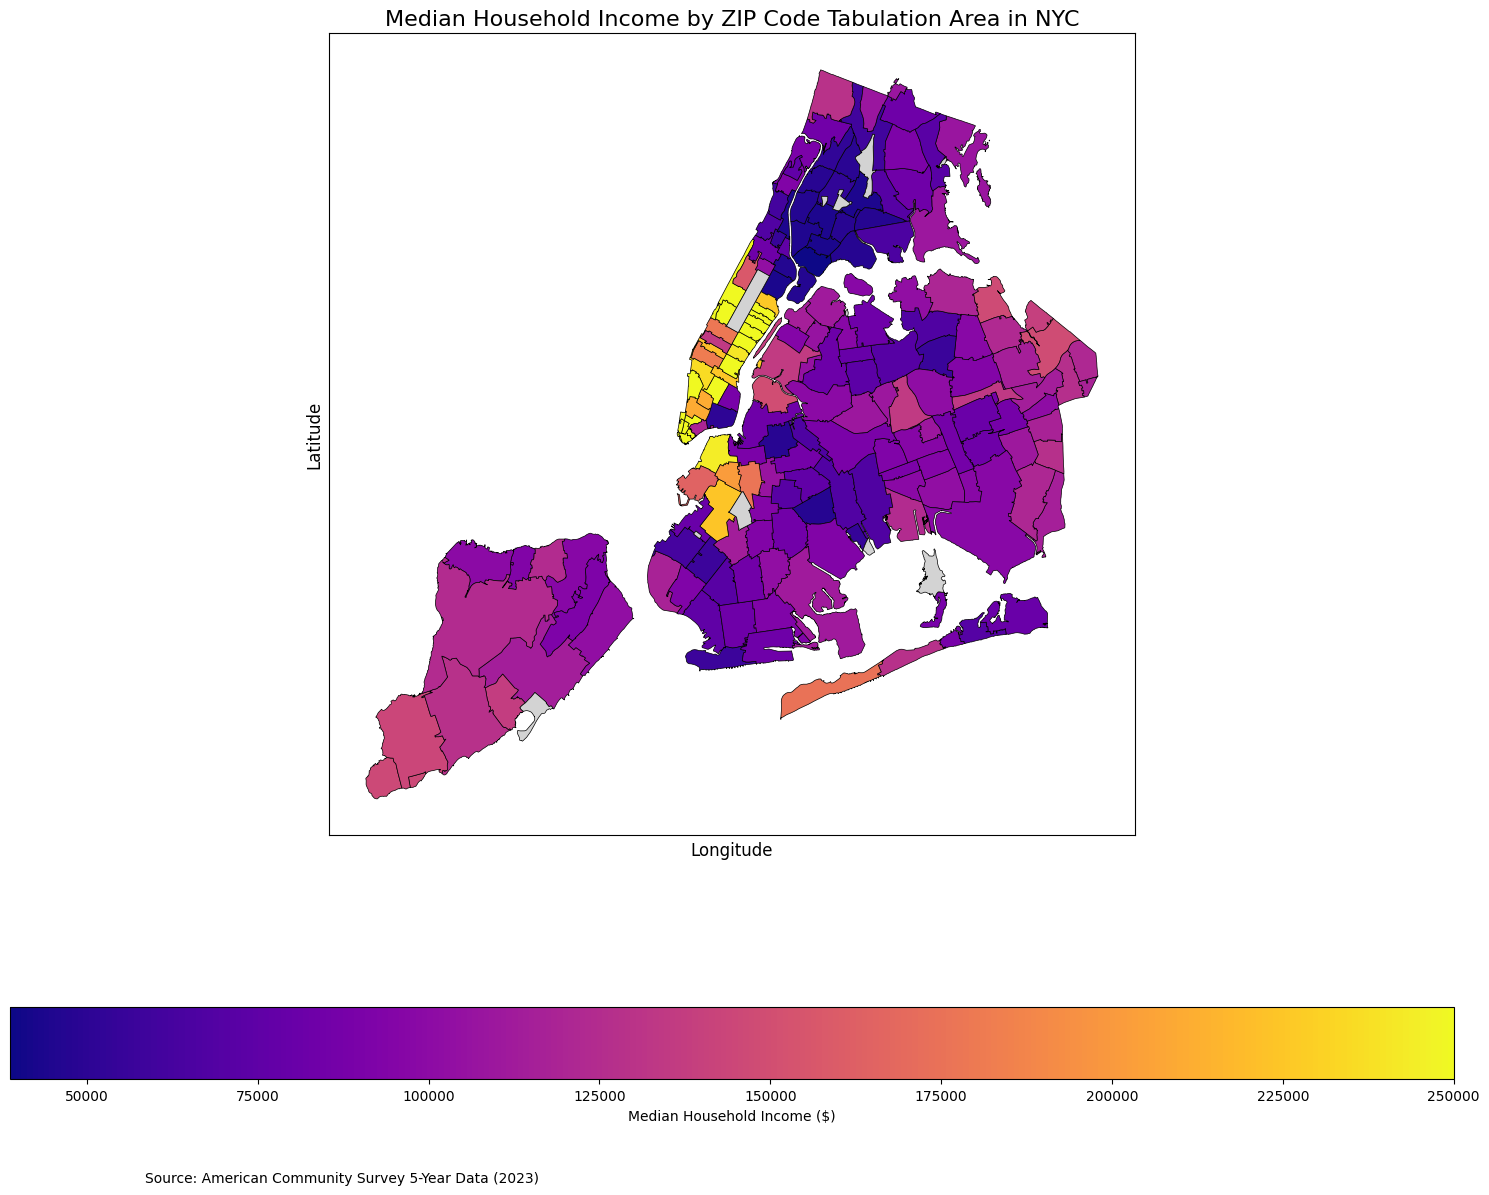

In [32]:

# Create a choropleth map of median household income
fig, ax = plt.subplots(1, figsize=(15, 12))

# Plot the map with income data
merged_gdf.plot(
    column='Median_Household_Income',
    ax=ax,
    legend=True,
    cmap='plasma',
    legend_kwds={'label': 'Median Household Income ($)', 'orientation': 'horizontal'},
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    edgecolor='black',
    linewidth=0.5,
    
)

# Add title and labels
ax.set_title('Median Household Income by ZIP Code Tabulation Area in NYC', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Remove axis ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Add source information
plt.figtext(0.1, 0.01, "Source: American Community Survey 5-Year Data (2023)", fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
raw_features_path = 'cleaned_data/merged_nyc_raw_features.geojson'
subway_data_path = 'data/subway-stations.geojson'
parking_data_path = 'data/DPR_ParkingLots_001_20250410.csv'
truck_routes_data_path = 'data/New_York_City_Truck_Routes_20250410.csv'
crime_data_path = 'data/grandlarceny.geojson'

def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

nyc_data = gpd.read_file('cleaned_data/merged_nyc_raw_features.geojson')

# Load the subway station data

subway_data = gpd.read_file(subway_data_path)

# Clean up subway data - remove stations with invalid geometries
subway_clean = subway_data[~subway_data.geometry.isna()]

# Calculate area in square kilometers for each ZIP code
nyc_data['area_sqkm'] = nyc_data.to_crs(epsg=32118).area / 1000000

# Count subway stations in each ZIP code
nyc_data['subway_count'] = 0
for idx, zip_area in nyc_data.iterrows():
    stations_in_area = subway_clean[subway_clean.intersects(zip_area.geometry)]
    nyc_data.at[idx, 'subway_count'] = len(stations_in_area)

# Calculate and normalize subway station density
nyc_data['subway_density'] = nyc_data['subway_count'] / nyc_data['area_sqkm']
nyc_data['subway_density_normalized'] = min_max_normalize(nyc_data['subway_density'])

parking_lots_df = pd.read_csv(parking_data_path)
# Convert WKT geometry to shapely objects
parking_lots_df['geometry'] = parking_lots_df['the_geom'].apply(wkt.loads)
# Create GeoDataFrame
parking_lots_gdf = gpd.GeoDataFrame(parking_lots_df, geometry='geometry', crs="EPSG:4326")

truck_routes_df = pd.read_csv(truck_routes_data_path)
# Convert WKT geometry to shapely objects
truck_routes_df['geometry'] = truck_routes_df['the_geom'].apply(wkt.loads)
# Create GeoDataFrame
truck_routes_gdf = gpd.GeoDataFrame(truck_routes_df, geometry='geometry', crs="EPSG:4326")
print(f"Found {len(truck_routes_gdf)} truck routes in NYC")

# Count parking lots in each ZIP code
print("Calculating parking lot availability by ZIP code...")
nyc_data['parking_lot_count'] = 0
for idx, zip_area in nyc_data.iterrows():
    parking_in_area = parking_lots_gdf[parking_lots_gdf.intersects(zip_area.geometry)]
    nyc_data.at[idx, 'parking_lot_count'] = len(parking_in_area)

# Calculate parking lot density (per sq km)
nyc_data['parking_density'] = nyc_data['parking_lot_count'] / nyc_data['area_sqkm']
nyc_data['parking_density_normalized'] = min_max_normalize(nyc_data['parking_density'])

# Calculate distance to nearest truck route for each ZIP code
print("Calculating proximity to truck routes...")
nyc_data['distance_to_truck_route'] = float('inf')
for idx, zip_area in nyc_data.iterrows():
    if idx % 10 == 0:  # Progress tracking
        print(f"Processing ZIP code {idx}/{len(nyc_data)}", end='\r')
    
    # Use centroid of ZIP code area
    centroid = zip_area.geometry.centroid
    
    # Find minimum distance to any truck route
    min_distance = float('inf')
    for _, route in truck_routes_gdf.iterrows():
        distance = centroid.distance(route.geometry)
        if distance < min_distance:
            min_distance = distance
    
    nyc_data.at[idx, 'distance_to_truck_route'] = min_distance


crime_data = gpd.read_file('data/grandlarceny.geojson')

# Make sure both datasets have the same CRS
if crime_data.crs != nyc_data.crs:
    crime_data = crime_data.to_crs(nyc_data.crs)

# Count crimes in each ZIP code area
nyc_data['crime_count'] = 0
for idx, zip_area in nyc_data.iterrows():
    crimes_in_area = crime_data[crime_data.intersects(zip_area.geometry)]
    nyc_data.at[idx, 'crime_count'] = len(crimes_in_area)

# Calculate crime density (crimes per sq km)
nyc_data['crime_density'] = nyc_data['crime_count'] / nyc_data['area_sqkm']

# Normalize crime density (inverse, since lower is better)
max_crime = nyc_data['crime_density'].max()
nyc_data['crime_density_inverse'] = max_crime - nyc_data['crime_density']
nyc_data['crime_normalized'] = (nyc_data['crime_density_inverse'] - nyc_data['crime_density_inverse'].min()) / (nyc_data['crime_density_inverse'].max() - nyc_data['crime_density_inverse'].min())

# Normalize truck route distance (inverse, since closer is better)
max_dist = nyc_data['distance_to_truck_route'].replace([np.inf], np.nan).max()
nyc_data['distance_to_truck_route_inverse'] = max_dist - nyc_data['distance_to_truck_route']
nyc_data['truck_route_normalized'] = min_max_normalize(nyc_data['distance_to_truck_route_inverse'])

# Also normalize the rent and home value data (inverse)
nyc_data['rent_inverse'] = nyc_data['Median_Gross_Rent'].max() - nyc_data['Median_Gross_Rent']
nyc_data['home_value_inverse'] = nyc_data['Median_Home_Value'].max() - nyc_data['Median_Home_Value']
nyc_data['rent_inverse_normalized'] = min_max_normalize(nyc_data['rent_inverse'])
nyc_data['home_value_inverse_normalized'] = min_max_normalize(nyc_data['home_value_inverse'])

# Filter for income > 120K
high_income_areas = nyc_data[nyc_data['Median_Household_Income'] > 120000].copy()
print(f"Number of high income ZIP areas (>$120K): {len(high_income_areas)}")

# Normalize population data
high_income_areas['Population_Normalized'] = min_max_normalize(high_income_areas['Total_Population'])
high_income_areas['Young_Adult_Normalized'] = min_max_normalize(high_income_areas['Percent_25_to_44'])
high_income_areas['White_Pop_Normalized'] = min_max_normalize(high_income_areas['Percent_White'])
high_income_areas['Asian_Pop_Normalized'] = min_max_normalize(high_income_areas['Percent_Asian'])


print(high_income_areas.head())
# Save the cleaned and processed data to a new file
output_path = 'cleaned_data/nyc_high_income_area_with_features.geojson'
high_income_areas.to_file(output_path, driver='GeoJSON')

/var/folders/92/b4ww7hzd5bd380sl60bc24m80000gn/T/ipykernel_53949/963205756.py:38: DtypeWarning: Columns (6,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  truck_routes_df = pd.read_csv(truck_routes_data_path)


Found 32939 truck routes in NYC
Calculating parking lot availability by ZIP code...
Calculating proximity to truck routes...
Number of high income ZIP areas (>$120K): 58
  modzcta         label                 zcta pop_est   ZCTA  \
0   10001  10001, 10118  10001, 10119, 10199   23072  10001   
2   10003         10003                10003   54682  10003   
4   10004         10004                10004    3028  10004   
5   10005         10005         10005, 10271    8831  10005   
6   10006         10006                10006    3454  10006   

   Median_Household_Income  Bachelors_Degree_or_Higher  Total_Population  \
0                 182117.0                     16248.0           29079.0   
2                 250000.0                     30039.0           53825.0   
4                 250000.0                      2736.0            3875.0   
5                 250000.0                      6172.0            9238.0   
6                 250000.0                      2941.0            4475.

In [14]:
# Define weights for each factor (adjust as needed)
weights = {
    'subway_density': 0.15,
    'parking_density': 0.15,
    'truck_route_proximity': 0.10,
    'rent_affordability': 0.15,
    'property_value': 0.10,
    'demographics': 0.15,
    'crime_safety': 0.20  # High weight for crime as it's a critical factor
}

# Calculate weighted score for high-income areas
high_income_areas = nyc_data[nyc_data['Median_Household_Income'] > 120000].copy()

high_income_areas['location_score'] = (
    (weights['subway_density'] * high_income_areas['subway_density_normalized']) +
    (weights['parking_density'] * high_income_areas['parking_density_normalized']) +
    (weights['truck_route_proximity'] * high_income_areas['truck_route_normalized']) +
    (weights['rent_affordability'] * high_income_areas['rent_inverse_normalized']) +
    (weights['property_value'] * high_income_areas['home_value_inverse_normalized']) +
    (weights['demographics'] * (high_income_areas['Young_Adult_Normalized'] + high_income_areas['White_Pop_Normalized'] + high_income_areas['Asian_Pop_Normalized'])/3) +
    (weights['crime_safety'] * high_income_areas['crime_normalized'])
)

# Sort by overall score
top_locations = high_income_areas.sort_values(by='location_score', ascending=False)

KeyError: 'White_Pop_Normalized'

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx

# Create a crime rate map
fig, ax = plt.subplots(1, figsize=(15, 12))

nyc_data.plot(
    column='crime_density',
    ax=ax,
    legend=True,
    cmap='Reds_r',  # Reversed red colormap so darker = more crime
    legend_kwds={'label': 'Crime Density (incidents per sq km)', 'orientation': 'horizontal'},
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    edgecolor='black',
    linewidth=0.5
)

ax.set_title('Grand Larceny Crime Density by ZIP Code in NYC', fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('crime_density_map.png', dpi=300)
plt.show()

# Create a map of top locations considering all factors including crime
fig, ax = plt.subplots(1, figsize=(15, 12))

# Plot all high-income areas with color based on score
top_locations.plot(
    column='location_score',
    ax=ax,
    legend=True,
    cmap='viridis',
    legend_kwds={'label': 'Location Score', 'orientation': 'horizontal'},
    edgecolor='black',
    linewidth=0.5
)

# Highlight top 5 areas
top_5 = top_locations.head(5)
top_5.plot(
    ax=ax,
    color='none',
    edgecolor='red',
    linewidth=2
)

# Label the top 5
for idx, row in top_5.iterrows():
    ax.annotate(row['ZCTA'], 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center',
                fontsize=12,
                color='red',
                fontweight='bold')

ax.set_title('Top Retail Location Recommendations\n(Including Crime Safety Factor)', fontsize=16)
ax.set_axis_off()

# Add basemap
ctx.add_basemap(ax, crs=top_locations.crs.to_string())

plt.tight_layout()
plt.savefig('top_retail_locations_with_crime.png', dpi=300)
plt.show()